In [1]:
#import the working library
import numpy as np
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [2]:
#read tickers as specified in excel in addition to market 
all_tickers = pd.read_excel('mapping.xlsx')[['Ticker', 'Market', 'Include']]
#list all tickers
all_tickers = all_tickers[all_tickers['Include']]
all_tickers

,Ticker,Market,Include
0,ARGT,Emerging,True
1,EWA,Developed,True
2,EWO,Developed,True
3,EWK,Developed,True
4,EWZ,Emerging,True
5,EWC,Developed,True
6,ECH,Emerging,True
7,MCHI,Emerging,True
12,EWQ,Developed,True
13,EWG,Developed,True


In [3]:
factor_description = pd.read_excel('factor description.xlsx', index_col='Short Name')
factor_description

,Name,Category
Short Name,,
mom_21,Short-term Absolute Momentum (21-trading day),Technical
mom_63,Medium-term Absolute Momentum (63-trading day),Technical
mom_252,Long-term Absolute Momentum (252-trading day),Technical
mr_21,Percentage over Short-term Moving Average (21-...,Technical
mr_63,Percentage over Medium-term Moving Average (63...,Technical
mr_252,Percentage over Long-term Moving Average (252-...,Technical
div_yield,Dividend Yield,Fundamental
pb,Price/Book Ratio,Fundamental
pe,Price/Earning Ratio,Fundamental


In [4]:
#specified date
start_date_train = '2016-01-01'
end_date_train = '2018-12-31'
start_date_test = '2019-01-01'
end_date_test = '2019-12-31'

In [5]:
results_df = pd.DataFrame()

# Technical

In [5]:
full_data = pd.read_csv('modeling data/technical.csv').dropna()

In [6]:
full_train = full_data.set_index('Date')[start_date_train:end_date_train]
full_test = full_data.set_index('Date')[start_date_test:end_date_test]
train_developed = full_train.reset_index().set_index('Market').loc['Developed'].reset_index().set_index(['Date', 'Market', 'Ticker'])
test_developed = full_test.reset_index().set_index('Market').loc['Developed'].reset_index().set_index(['Date', 'Market', 'Ticker'])
train_emerging = full_train.reset_index().set_index('Market').loc['Emerging'].reset_index().set_index(['Date', 'Market', 'Ticker'])
test_emerging = full_test.reset_index().set_index('Market').loc['Emerging'].reset_index().set_index(['Date', 'Market', 'Ticker'])

## Developed Market

In [7]:
train_data = train_developed
test_data = test_developed

### Random Forest Regressor

In [8]:
model_name = 'technical_developed_rfr'

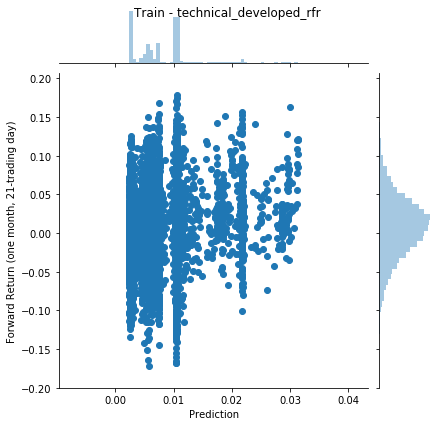

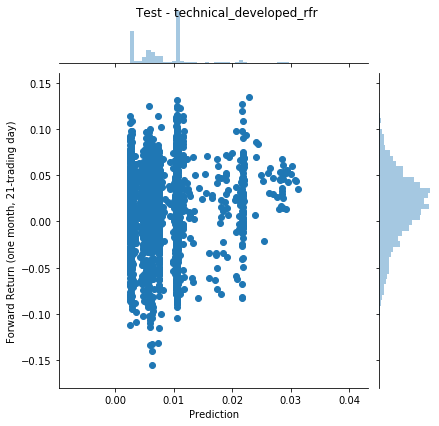

In [9]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = RandomForestRegressor(n_estimators=10000, max_depth=2, min_samples_leaf=30, min_samples_split=60, random_state=2020)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

### Ridge Regression

In [10]:
model_name = 'technical_developed_ridge'

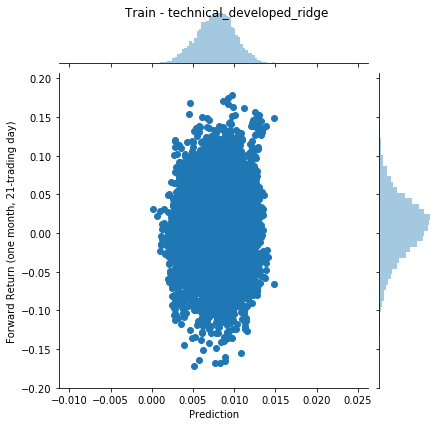

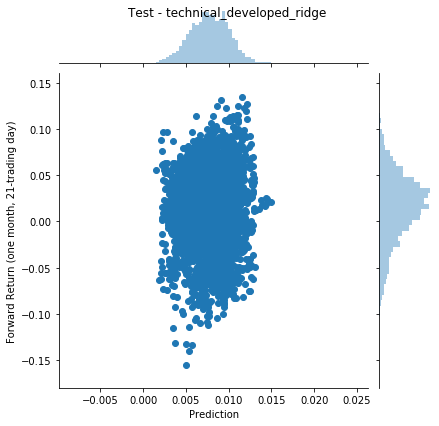

In [11]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = Ridge(alpha=.5)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

##  Emerging Market

In [12]:
train_data = train_emerging
test_data = test_emerging

### Random Forest Regressor

In [13]:
model_name = 'technical_emerging_rfr'

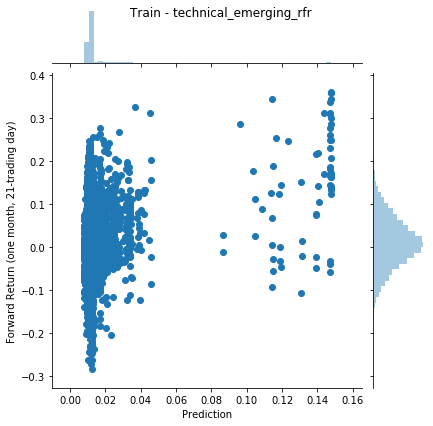

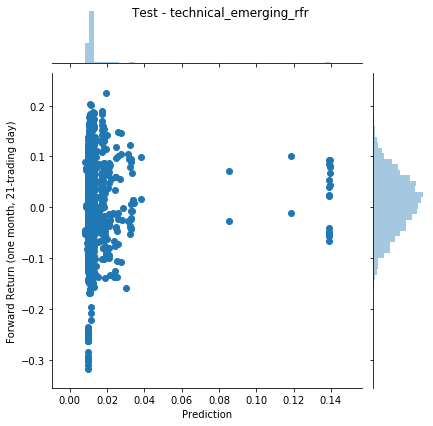

In [14]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = RandomForestRegressor(n_estimators=10000, max_depth=2, min_samples_leaf=30, min_samples_split=60, random_state=2020)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

### Ridge Regression

In [15]:
model_name = 'technical_emerging_ridge'

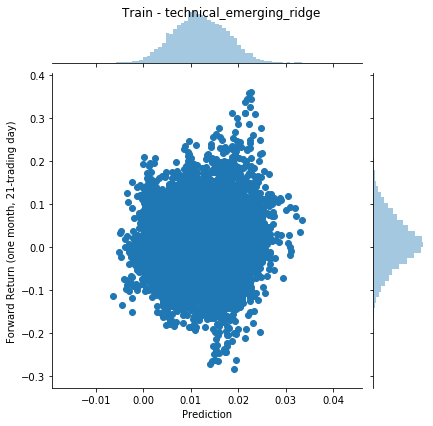

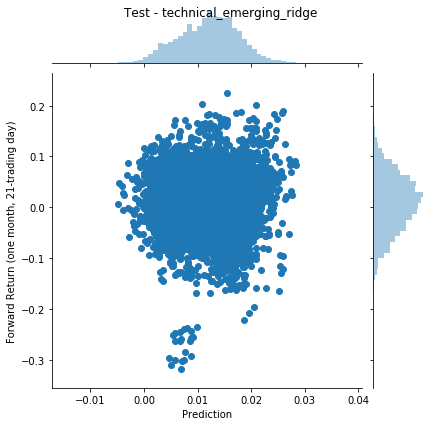

In [16]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = Ridge(alpha=.5)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

# Fundamental

In [17]:
full_data = pd.read_csv('modeling data/fundamental.csv').dropna()

In [18]:
full_train = full_data.set_index('Date')[start_date_train:end_date_train]
full_test = full_data.set_index('Date')[start_date_test:end_date_test]
train_developed = full_train.reset_index().set_index('Market').loc['Developed'].reset_index().set_index(['Date', 'Market', 'Ticker'])
test_developed = full_test.reset_index().set_index('Market').loc['Developed'].reset_index().set_index(['Date', 'Market', 'Ticker'])
train_emerging = full_train.reset_index().set_index('Market').loc['Emerging'].reset_index().set_index(['Date', 'Market', 'Ticker'])
test_emerging = full_test.reset_index().set_index('Market').loc['Emerging'].reset_index().set_index(['Date', 'Market', 'Ticker'])

## Developed Market

In [19]:
train_data = train_developed
test_data = test_developed

### Random Forest Regressor

In [20]:
model_name = 'fundamental_developed_rfr'

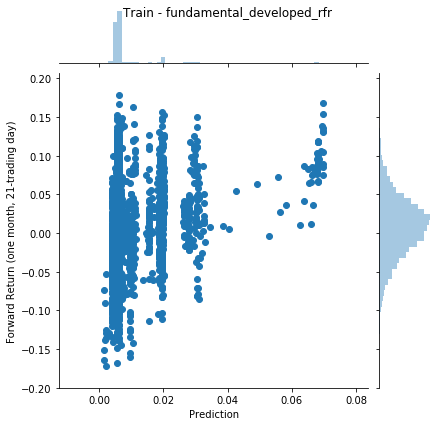

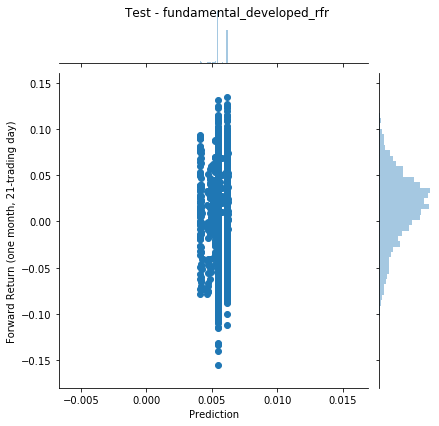

In [21]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = RandomForestRegressor(n_estimators=10000, max_depth=2, min_samples_leaf=30, min_samples_split=60, random_state=2020)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

### Ridge Regression

In [22]:
model_name = 'fundamental_developed_ridge'

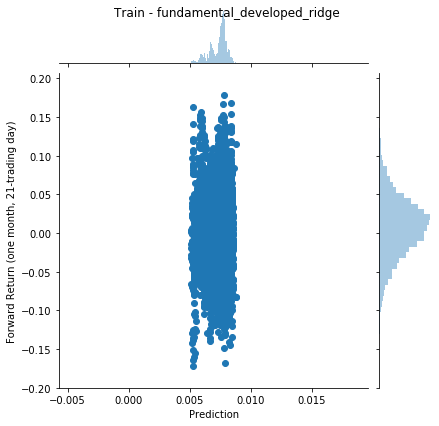

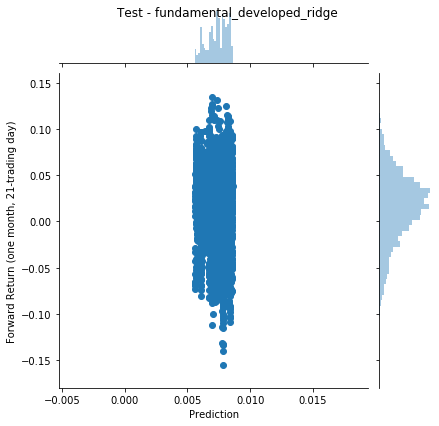

In [23]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = Ridge(alpha=.5)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

##  Emerging Market

In [24]:
train_data = train_emerging
test_data = test_emerging

### Random Forest Regressor

In [25]:
model_name = 'fundamental_emerging_rfr'

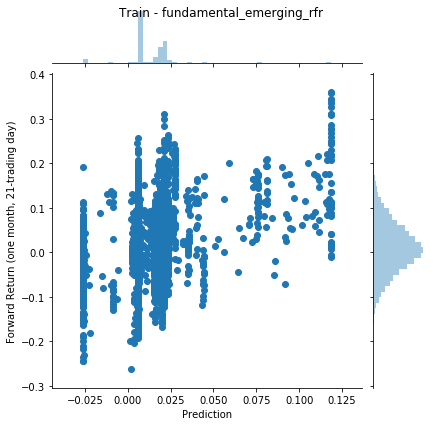

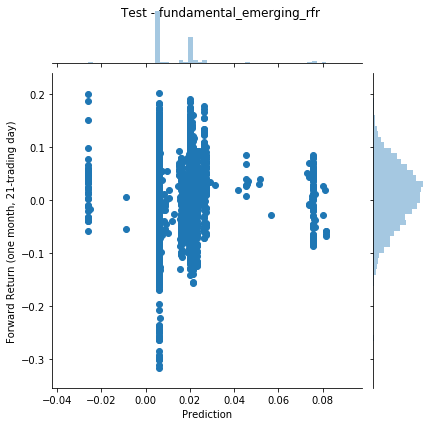

In [26]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = RandomForestRegressor(n_estimators=10000, max_depth=2, min_samples_leaf=30, min_samples_split=60, random_state=2020)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

### Ridge Regression

In [27]:
model_name = 'fundamental_emerging_ridge'

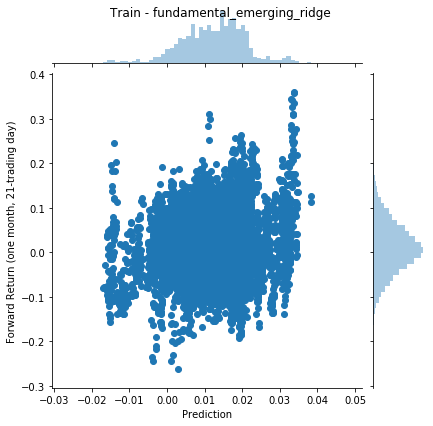

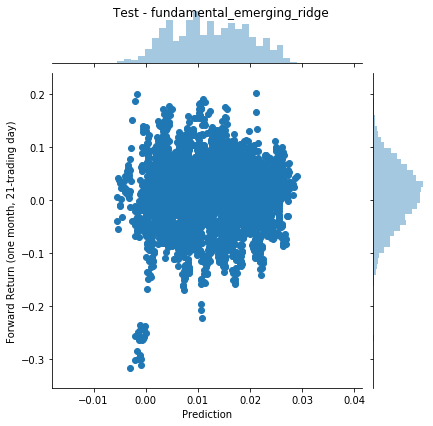

In [28]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = Ridge(alpha=.5)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

# Economic

In [29]:
full_data = pd.read_csv('modeling data/economic.csv').dropna()

In [30]:
full_train = full_data.set_index('Date')[start_date_train:end_date_train]
full_test = full_data.set_index('Date')[start_date_test:end_date_test]
train_developed = full_train.reset_index().set_index('Market').loc['Developed'].reset_index().set_index(['Date', 'Market', 'Ticker'])
test_developed = full_test.reset_index().set_index('Market').loc['Developed'].reset_index().set_index(['Date', 'Market', 'Ticker'])
train_emerging = full_train.reset_index().set_index('Market').loc['Emerging'].reset_index().set_index(['Date', 'Market', 'Ticker'])
test_emerging = full_test.reset_index().set_index('Market').loc['Emerging'].reset_index().set_index(['Date', 'Market', 'Ticker'])

## Developed Market

In [31]:
train_data = train_developed
test_data = test_developed

### Random Forest Regressor

In [32]:
model_name = 'economic_developed_rfr'

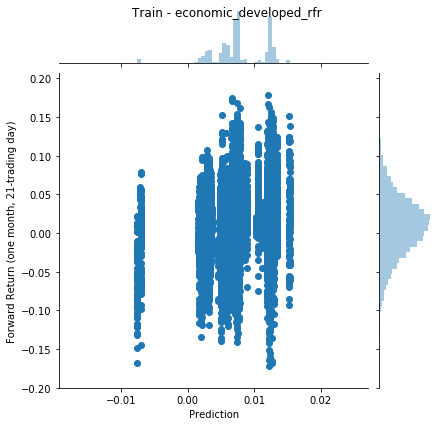

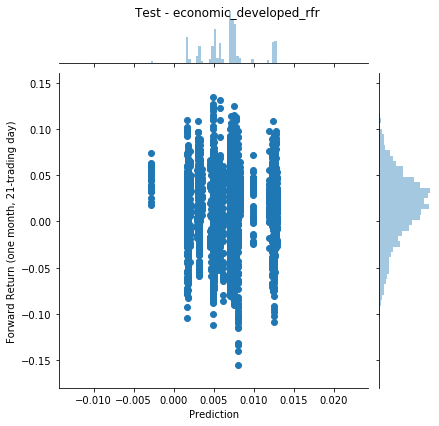

In [33]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = RandomForestRegressor(n_estimators=10000, max_depth=2, min_samples_leaf=30, min_samples_split=60, random_state=2020)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

### Ridge Regression

In [34]:
model_name = 'economic_developed_ridge'

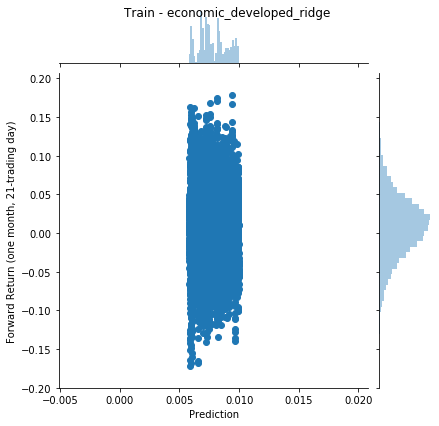

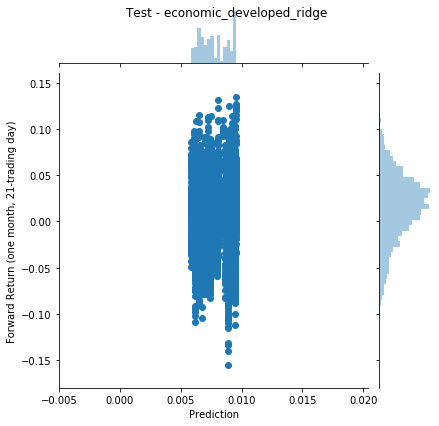

In [35]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = Ridge(alpha=.5)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

##  Emerging Market

In [36]:
train_data = train_emerging
test_data = test_emerging

### Random Forest Regressor

In [37]:
model_name = 'economic_emerging_rfr'

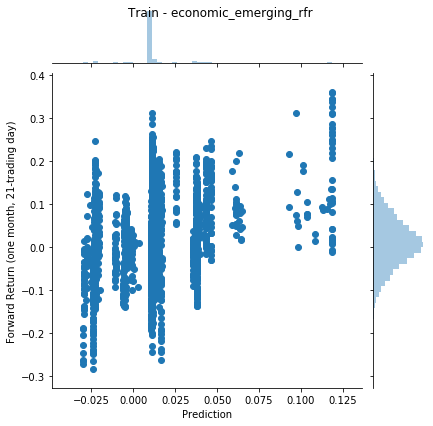

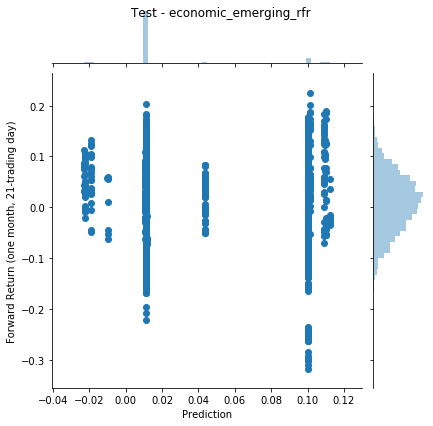

In [38]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = RandomForestRegressor(n_estimators=10000, max_depth=2, min_samples_leaf=30, min_samples_split=60, random_state=2020)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

### Ridge Regression

In [39]:
model_name = 'economic_emerging_ridge'

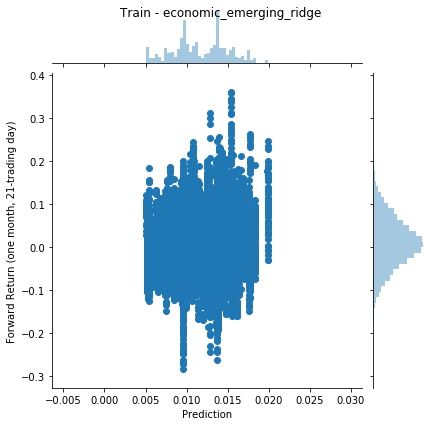

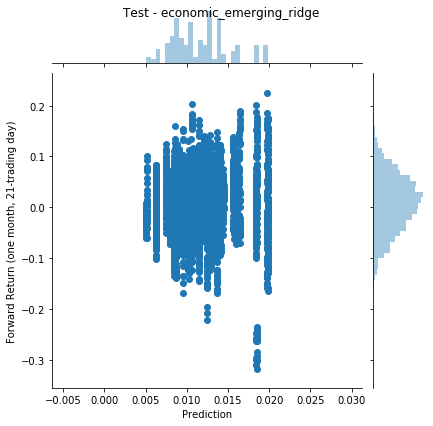

In [40]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = Ridge(alpha=.5)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

# Sentimental and Alternative

In [41]:
full_data = pd.read_csv('modeling data/sentimental_and_alternative.csv').dropna()

In [42]:
full_train = full_data.set_index('Date')[start_date_train:end_date_train]
full_test = full_data.set_index('Date')[start_date_test:end_date_test]
train_developed = full_train.reset_index().set_index('Market').loc['Developed'].reset_index().set_index(['Date', 'Market', 'Ticker'])
test_developed = full_test.reset_index().set_index('Market').loc['Developed'].reset_index().set_index(['Date', 'Market', 'Ticker'])
train_emerging = full_train.reset_index().set_index('Market').loc['Emerging'].reset_index().set_index(['Date', 'Market', 'Ticker'])
test_emerging = full_test.reset_index().set_index('Market').loc['Emerging'].reset_index().set_index(['Date', 'Market', 'Ticker'])

## Developed Market

In [43]:
train_data = train_developed
test_data = test_developed

### Random Forest Regressor

In [44]:
model_name = 'sentimental_and_alternative_developed_rfr'

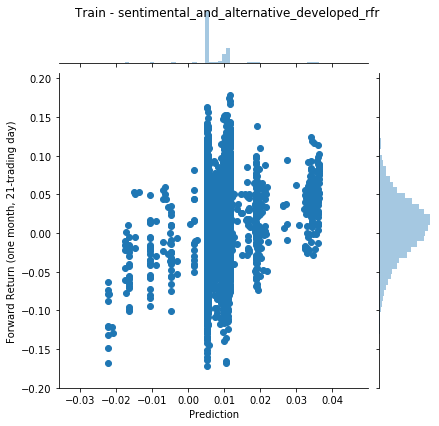

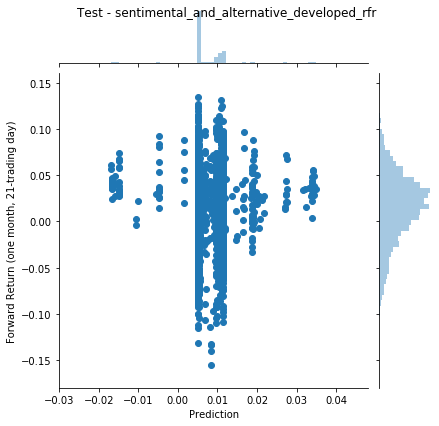

In [45]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = RandomForestRegressor(n_estimators=10000, max_depth=2, min_samples_leaf=30, min_samples_split=60, random_state=2020)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

### Ridge Regression

In [46]:
model_name = 'sentimental_and_alternative_developed_ridge'

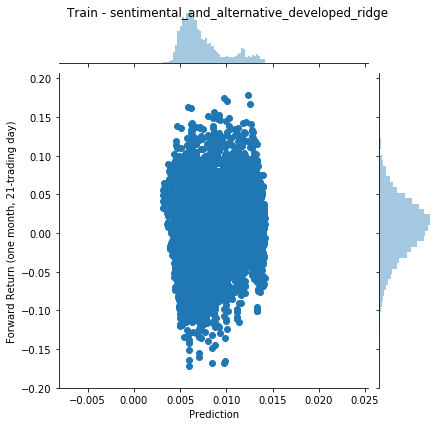

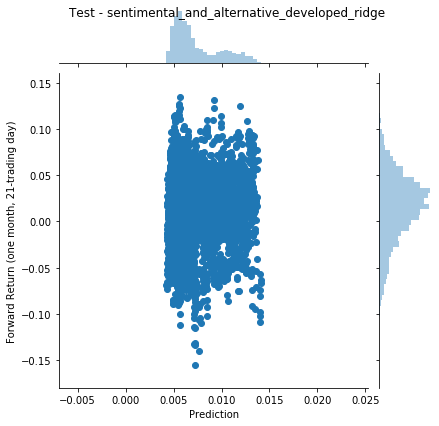

In [47]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = Ridge(alpha=.5)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

##  Emerging Market

In [48]:
train_data = train_emerging
test_data = test_emerging

### Random Forest Regressor

In [49]:
model_name = 'sentimental_and_alternative_emerging_rfr'

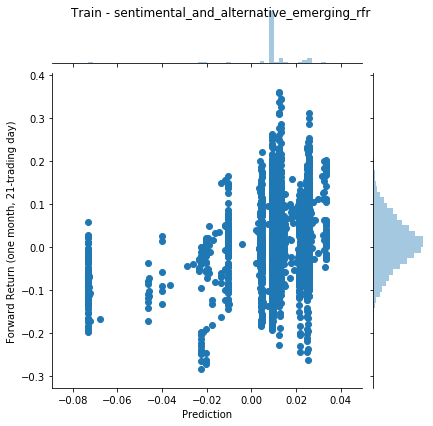

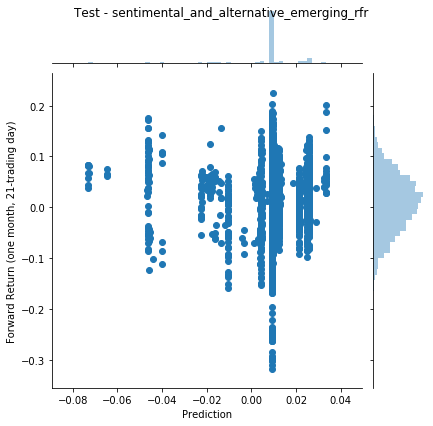

In [50]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = RandomForestRegressor(n_estimators=10000, max_depth=2, min_samples_leaf=30, min_samples_split=60, random_state=2020)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

### Ridge Regression

In [51]:
model_name = 'sentimental_and_alternative_emerging_ridge'

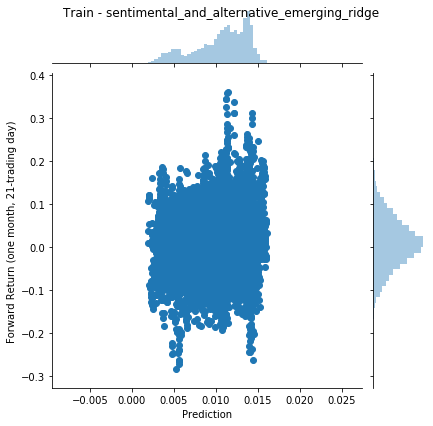

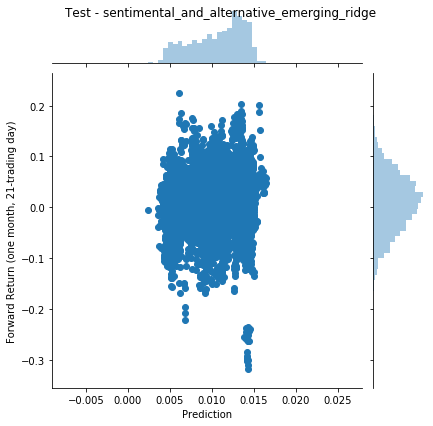

In [52]:
if os.path.exists('models/'+model_name+'.sav'):
    model = joblib.load('models/'+model_name+'.sav')
else:
    model = Ridge(alpha=.5)
    model.fit(train_data[train_data.columns[1:]], train_data['f_rtn'])
    joblib.dump(model, 'models/'+model_name+'.sav')
plot_df = train_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Train - '+model_name)
plt.savefig('models/Train - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Train'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_train'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_train']].to_csv('models/'+model_name+'_train.csv')
plot_df = test_data.rename({'f_rtn': 'Forward Return (one month, 21-trading day)'}, axis=1)
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)
g.fig.suptitle('Test - '+model_name)
plt.savefig('models/Test - '+model_name+'.png')
plt.show()
results_df.loc[model_name, 'Test'] = mean_squared_error(plot_df['Forward Return (one month, 21-trading day)'], plot_df['Prediction'])
plot_df.rename({'Prediction': model_name+'_test'}, 
               axis=1)[['Forward Return (one month, 21-trading day)', model_name+'_test']].to_csv('models/'+model_name+'_test.csv')

In [53]:
results_df.to_csv('models/results.csv')

In [54]:
results_df

,Train,Test
technical_developed_rfr,0.001661,0.001486
technical_developed_ridge,0.001687,0.001476
technical_emerging_rfr,0.003920,0.003921
technical_emerging_ridge,0.004009,0.003885
fundamental_developed_rfr,0.001599,0.001509
fundamental_developed_ridge,0.001653,0.001490
fundamental_emerging_rfr,0.003531,0.003946
fundamental_emerging_ridge,0.003784,0.003833
economic_developed_rfr,0.001655,0.001503
economic_developed_ridge,0.001691,0.001477


# Final Model

## Developed Market

In [5]:
market = 'developed'
factors = ['technical']

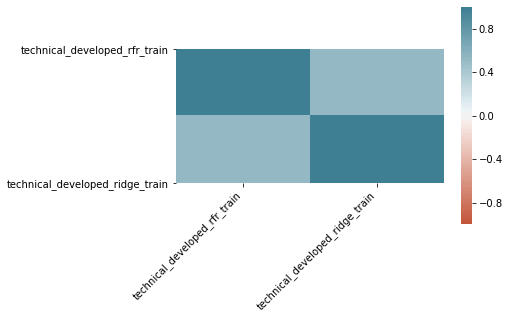

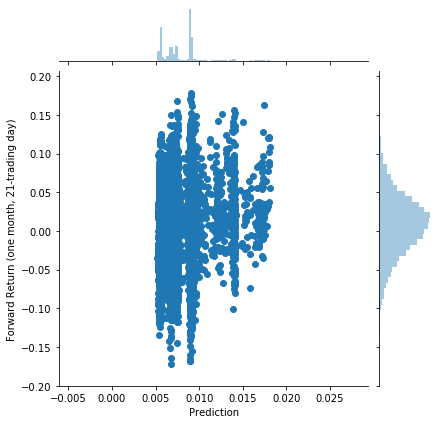

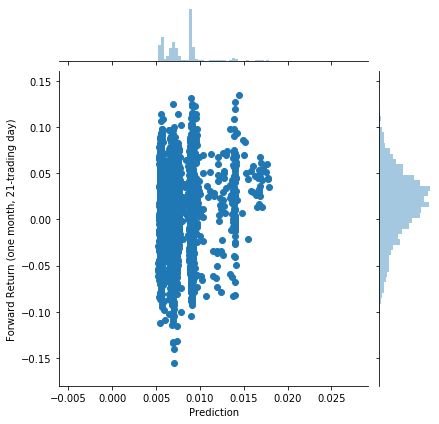

In [6]:
models = ['rfr', 'ridge']

dataset = 'train'
data_files = np.array([[factor+'_'+market+'_'+model+'_'+dataset+'.csv' for factor in factors] for model in models]).flatten()
full_data = None
for data_file in data_files:
    if full_data is None:
        full_data = pd.read_csv('models/'+data_file).set_index(['Date', 'Market', 'Ticker'])
    else:
        full_data = full_data.join(pd.read_csv('models/'+data_file).set_index(['Date', 'Market', 'Ticker']).drop('Forward Return (one month, 21-trading day)', axis=1), how='outer')
corr = full_data.dropna()[full_data.columns[1:]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
);
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

train_data = full_data.dropna()
if os.path.exists('models/developed.sav'):
    model = joblib.load('models/developed.sav')
else:
    model = Ridge(alpha=.5)
    model.fit(train_data[train_data.columns[1:]], train_data['Forward Return (one month, 21-trading day)'])
    joblib.dump(model, 'models/developed.sav')
plot_df = train_data
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)

dataset = 'test'
data_files = np.array([[factor+'_'+market+'_'+model+'_'+dataset+'.csv' for factor in factors] for model in models]).flatten()
full_data = None
for data_file in data_files:
    if full_data is None:
        full_data = pd.read_csv('models/'+data_file).set_index(['Date', 'Market', 'Ticker'])
    else:
        full_data = full_data.join(pd.read_csv('models/'+data_file).set_index(['Date', 'Market', 'Ticker']).drop('Forward Return (one month, 21-trading day)', axis=1), how='outer')
train_data = full_data.dropna()
plot_df = train_data
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)

In [9]:
plot_df.to_csv('models/developed_predication.csv')

## Emerging Market

In [10]:
market = 'emerging'
factors = ['technical', 'fundamental', 'economic', 'sentimental_and_alternative']

C:\Users\Desktop User\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Desktop User\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


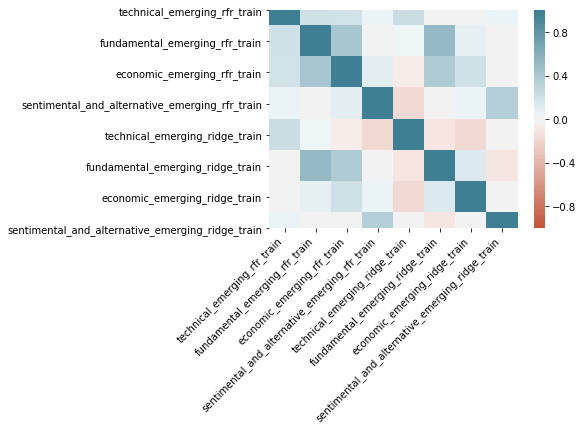

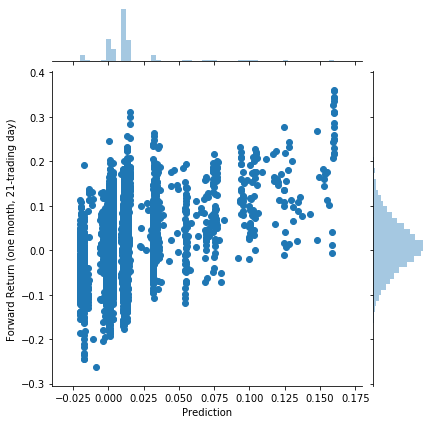

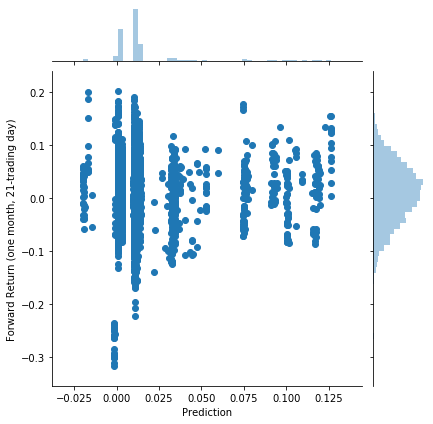

In [11]:
models = ['rfr', 'ridge']

dataset = 'train'
data_files = np.array([[factor+'_'+market+'_'+model+'_'+dataset+'.csv' for factor in factors] for model in models]).flatten()
full_data = None
for data_file in data_files:
    if full_data is None:
        full_data = pd.read_csv('models/'+data_file).set_index(['Date', 'Market', 'Ticker'])
    else:
        full_data = full_data.join(pd.read_csv('models/'+data_file).set_index(['Date', 'Market', 'Ticker']).drop('Forward Return (one month, 21-trading day)', axis=1), how='outer')
corr = full_data.dropna()[full_data.columns[1:]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
);
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

train_data = full_data.dropna()
if os.path.exists('models/emerging.sav'):
    model = joblib.load('models/emerging.sav')
else:
    model = RandomForestRegressor(n_estimators=10000, max_depth=2, min_samples_leaf=30, min_samples_split=60, random_state=2020)
    model.fit(train_data[train_data.columns[1:]], train_data['Forward Return (one month, 21-trading day)'])
    joblib.dump(model, 'models/emerging.sav')
plot_df = train_data
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)

dataset = 'test'
data_files = np.array([[factor+'_'+market+'_'+model+'_'+dataset+'.csv' for factor in factors] for model in models]).flatten()
full_data = None
for data_file in data_files:
    if full_data is None:
        full_data = pd.read_csv('models/'+data_file).set_index(['Date', 'Market', 'Ticker'])
    else:
        full_data = full_data.join(pd.read_csv('models/'+data_file).set_index(['Date', 'Market', 'Ticker']).drop('Forward Return (one month, 21-trading day)', axis=1), how='outer')
train_data = full_data.dropna()
plot_df = train_data
plot_df['Prediction'] = model.predict(plot_df[plot_df.columns[1:]])
g = sns.jointplot('Prediction', 'Forward Return (one month, 21-trading day)', data=plot_df)

In [12]:
plot_df.to_csv('models/emerging_predication.csv')

# Backtest Inputs

In [37]:
rebalance_dates = ['2019-01-02', '2019-02-01', '2019-03-01', 
                   '2019-04-01', '2019-05-01', '2019-06-03', 
                   '2019-07-01', '2019-08-01', '2019-09-03',
                   '2019-10-01', '2019-11-01', '2019-12-02']

In [38]:
developed_df = pd.read_csv('models/developed_predication.csv')
emerging_df = pd.read_csv('models/emerging_predication.csv')

In [39]:
data_df = developed_df[['Date', 'Market', 'Ticker', 'Prediction']].set_index(['Date', 'Market', 'Ticker']).loc[rebalance_dates]
total_weight = 0.5
data_df['Weight'] = 0
for date in rebalance_dates:
    data_df.loc[date, 'Weight'] = (data_df.loc[date, 'Prediction']/data_df.loc[date, 'Prediction'].abs().sum()*total_weight).values
developed_df = data_df

In [40]:
data_df = emerging_df[['Date', 'Market', 'Ticker', 'Prediction']].set_index(['Date', 'Market', 'Ticker']).loc[rebalance_dates]
total_weight = 0.5
data_df['Weight'] = 0
for date in rebalance_dates:
    data_df.loc[date, 'Weight'] = (data_df.loc[date, 'Prediction']/data_df.loc[date, 'Prediction'].abs().sum()*total_weight).values
emerging_df = data_df

In [41]:
combined_df = pd.concat([developed_df.reset_index(), emerging_df.reset_index()], axis=0, ignore_index=True).sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])

In [42]:
for ticker, market in zip(all_tickers['Ticker'], all_tickers['Market']):
    for date in rebalance_dates:
        if ticker not in combined_df.loc[date].loc[market].index:
            print(date)
            print(market)
            print(ticker)
            combined_df.loc[(date, market, ticker), 'Weight'] = 0

2019-01-02
Emerging
EIDO
2019-02-01
Emerging
EIDO
2019-03-01
Emerging
EIDO


C:\Users\Desktop User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


2019-01-02
Emerging
TUR
2019-02-01
Emerging
TUR
2019-03-01
Emerging
TUR


In [43]:
for ticker, market in zip(all_tickers['Ticker'], all_tickers['Market']):
    for date in rebalance_dates:
        if ticker not in combined_df.loc[date].loc[market].index:
            print(date)
            print(market)
            print(ticker)
            combined_df.loc[(date, market, ticker), 'Weight'] = 0

In [44]:
combined_df.reset_index().sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker']).reset_index().rename({'Ticker': 'symbol'}, axis=1).to_csv('backtest_inputs.csv', index=False)

In [45]:
for date in rebalance_dates:
    print(combined_df.loc[date].shape)

(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
